The [Numerov method][numerov] is used to solve differential equations of the form

$$\frac{d^2 y}{dx^2} = - g(x) y(x) + s(x)$$

In the case of the 1D time-independent Schr&ouml;dinger equation for a quantum object of mass $m$ with energy $E$ subjected to a potential $V(x)$, we have (upon rearranging)

$$\frac{d^2 \psi}{dx^2} = -\frac{2m(E-V(x))}{\hbar^2}\psi,$$

where $\psi(x)$ is the wavefunction of the quantum object. From this point, we need to find natural units with which to nondimensionalize the differential equation. The natural units typically depend on the specific problem. In atomic/molecular physics, it is common to use [atomic units][au] based on the properties of the hydrogen atom. For other general problems, the natural units are found in the Schr&ouml;dinger equation itself.

Take, for instance, the simple harmonic oscillator (classical problem of the mass on a spring). The potential energy takes the form 

$$V(x) = \frac{1}{2} kx^2 = \frac{1}{2} m\omega^2 x^2,$$

where $k$ is the spring constant and $\omega$ is the natural (angular) frequency of oscillation. The natural units for this system are derived from factors of $m$, $\omega$, and $\hbar$. For instance, the natural energy unit is $\hbar\omega$, while the natural unit of distance is $\sqrt{\hbar/m\omega}$. Thus, we define the dimensionless distance $\xi = x\sqrt{m\omega/\hbar}$, and our rearranged Schr&ouml;dinger equation becomes

$$\frac{d^2 \psi}{d\xi^2} = -\frac{2(E-V(\xi))}{\hbar\omega}\psi.$$

[numerov]: https://en.wikipedia.org/wiki/Numerov%27s_method "wiki:Numerov's method"
[au]: https://en.wikipedia.org/wiki/Hartree_atomic_units "wiki:Hartree atomic units"

It should be evident now that this equation is dimensionless. Comparing our dimensionless Schr&ouml;dinger equation with the first differential equation, we can identify
* $x \to \xi$
* $y \to \psi$
* $g(x) \to 2(E-V(\xi))/\hbar\omega$


Computationally, the Numerov method relates these quantities to each other in the following way:

$$
\begin{align}
\psi_{n+1} \left(1 + \frac{(\Delta \xi)^2}{12} \frac{2 (E-V_{n+1})}{\hbar\omega} \right) 
&= 2 \psi_n \left(1 - \frac{5 (\Delta \xi)^2}{12} \frac{2(E-V_{n})}{\hbar\omega} \right)\\ 
&\!\quad - \psi_{n-1} \left(1 + \frac{(\Delta \xi)^2}{12} \frac{2(E-V_{n-1})}{\hbar\omega} \right) \\
&\!\quad + \mathcal{O} \left((\Delta \xi)^6 \right).
\end{align}
$$

We can also write this in matrix notation as (Pillai, Goglio, and Walker, [*Am. J. Phys.*][AJPNumerov] **80**, 1017 (2012), [PDF][NumerovPDF])

$$A \, \psi = -2B\, \frac{(E-V)}{\hbar\omega}\psi$$

where 

$$A = \frac{1}{(\Delta \xi)^2}
\begin{pmatrix}
-2 & 1 & 0 & 0 & \cdots \\
1 & -2 & 1 & 0 &\cdots \\
0 & 1 & -2 & 1 & \cdots \\
0 & 0 &  1 & -2 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
, \quad
B = \frac{1}{12}
\begin{pmatrix}
10 & 1 & 0 & 0 & \cdots \\
1 & 10 & 1 & 0 &\cdots \\
0 & 1 & 10 & 1 & \cdots \\
0 & 0 &  1 & 10 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix},
$$

$\psi$ is treated as a column vector, and $V$ is a diagonal matrix. We can rearrange this to get an eigenvalue equation,

$$\left(-\frac{1}{2} B^{-1}A + \frac{V}{\hbar\omega}\right)\psi = \frac{E}{\hbar\omega}\psi,$$

where we can see that

$$H = -\frac{1}{2} B^{-1}A + \frac{V}{\hbar\omega}$$

is the Hamiltonian in the Numerov representation. Finding the eigenvalues of this matrix will yield the energies of the system.

[AJPNumerov]: http://dx.doi.org/10.1119/1.4748813 "AJP Numerov paper"
[NumerovPDF]: https://pages.physics.wisc.edu/~tgwalker/106.Numerov.pdf "Numerov Paper PDF"

Here I'm going to attempt to write code to run the Numerov method on arbitrary potential functions. Our first step is to import the necessary packages we will need.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

Next, we need to construct the arrays for our potential energy function, its domain, and the A and B matrices that arise from both.

In [2]:
xmax = 10
npts = 2**11
x = np.linspace(-xmax, xmax, num=npts, endpoint=True)
dx = (2*xmax)/(npts-1)
# Construct the potential
# SHO
Vx = 0.5*x**2
# Abs value
# Vx = abs(x)

# Construct A and B matrices
A = dx**(-2)*(np.diag(np.ones(len(x)-1), -1) - 2.*np.diag(np.ones(len(x)), 0) + np.diag(np.ones(len(x)-1), 1))
B = 1./12*(np.diag(np.ones(len(x)-1), -1) + 10.*np.diag(np.ones(len(x)), 0) + np.diag(np.ones(len(x)-1), 1))

# Construct V matrix
V = np.diag(Vx)

This next part is quite computationally intensive. Here we invert $B$ and get the eigenvalues $E$ and eigenvectors $\psi$ of $H$.

In [3]:
# Take inverse of B
Binv = np.linalg.inv(B)
Hmat = -0.5 * np.dot(Binv, A) + V
# Hmat = -np.dot(Binv, A) + V
# Get eigenvalues and eigenvectors (psi) of Hamiltonian.
en, psi = np.linalg.eigh(Hmat)
# Normalize the wavefunctions
psi = psi/dx**0.5

# r2inv=[]
# for v in range(0,len(en)-1):
#     if en[v] < 0.5*xmax**2:
#        psiint = interp1d(Rint, psi[:,v]*psi[:,v], kind='cubic')
#        norm = sp.integrate.simps(psi[:,v]**2, x)
#        psi[:,v] = psi[:,v]/norm**0.5
#        r2inv.append(sp.integrate.simps(psi[:,v]**2 / x**2, x))

Here the wavefunctions are plotted over the potential energy well. Note that the at the classical turning points, the wavefunction has an inflection point beyond which it decays rapidly to zero in the classically forbidden region.

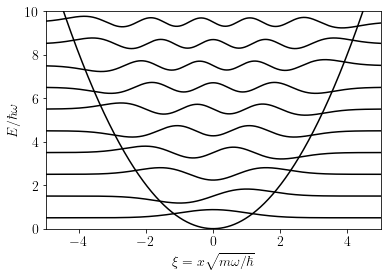

In [4]:
plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='14')
plt.xlim([-xmax/2, xmax/2])
plt.ylim([0, xmax])
plt.xlabel('$\\xi = x\sqrt{m\\omega/\\hbar}$')
# plt.xlabel('$\\xi = z/z_0$')
plt.ylabel('$E/\\hbar\\omega$')
# plt.ylabel('$E/mgz_0$')
plt.plot(x, Vx, 'k-')
for v in range(len(en)):
    if en[v] < max(Vx):
        plt.plot(x, (-1)**(v+1)*0.5*psi[:,v] + en[v], 'k-')
# plt.savefig('AbsWellwvfcns.svg')
# plt.savefig('SHOwvfcns.svg')

This next plot is the potential well with the probability densities $|\psi(x)|^2$ superimposed. The pattern is quite pleasing.

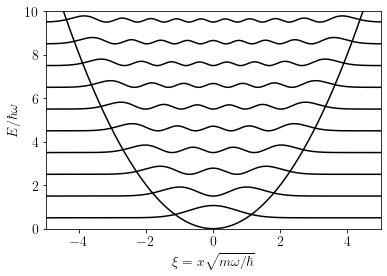

In [5]:
plt.figure()
plt.xlim([-xmax/2, xmax/2])
plt.ylim([0, xmax])
plt.xlabel('$\\xi = x\sqrt{m\\omega/\\hbar}$')
# plt.xlabel('$\\xi = z/z_0$')
plt.ylabel('$E/\\hbar\\omega$')
# plt.ylabel('$E/mgz_0$')
plt.plot(x, Vx, 'k-')
for v in range(len(en)):
    if en[v] < max(Vx):
        plt.plot(x, psi[:,v]*psi[:,v] + en[v], 'k')
# plt.savefig('AbsWellProb.svg')
# plt.savefig('SHOprob.svg')

It's helpful to see how accurately the Numerov method reproduced the known energies of the harmonic oscillator. In the natural units used above, the energy eigenvalues occur at $n+1/2$. This loop finds the percent error,

$$100\% \times \left(\frac{\text{calculated value}}{\text{actual value}} -1 \right),$$

as a comparison. Only at the highest $n$ values does the percent error get close to 1%, and even then it does not cross the 1% threshold.

In [7]:
# This lists the percent error for each energy of the SHO
print('n', '\t', '% error', '\n')
for i in range(int(len(en)/2)):
    if en[i] < max(Vx):
        print(i, '\t', 100*(en[i]-i-.5)/(i+.5))

n 	 % error 

0 	 -6.548495079528038e-09
1 	 -1.654255991449342e-08
2 	 -3.548164428934797e-08
3 	 -6.409226165666431e-08
4 	 -1.0202031811938166e-07
5 	 -1.495006623548017e-07
6 	 -2.064658871220742e-07
7 	 -2.7291540286948174e-07
8 	 -3.4885098731298485e-07
9 	 -4.3430531685604176e-07
10 	 -5.292379783094518e-07
11 	 -6.336705846034301e-07
12 	 -7.475986194549478e-07
13 	 -8.710120493173303e-07
14 	 -1.0039193874678764e-06
15 	 -1.1463277638951342e-06
16 	 -1.2982280247452955e-06
17 	 -1.45962514709806e-06
18 	 -1.6305257396517256e-06
19 	 -1.8109106237354867e-06
20 	 -2.0007967878693928e-06
21 	 -2.200178726546488e-06
22 	 -2.4090632817003807e-06
23 	 -2.6274369309084386e-06
24 	 -2.8553130399749146e-06
25 	 -3.0926732303633603e-06
26 	 -3.339509445496796e-06
27 	 -3.5957251043328142e-06
28 	 -3.860886123088915e-06
29 	 -4.133108734357062e-06
30 	 -4.4046707381633e-06
31 	 -4.645533177186475e-06
32 	 -4.745207648354083e-06
33 	 -4.319014824058788e-06
34 	 -2.1006591300581508e-06
35 

In [ ]:
# This is the percent error for Airy wavefunctions

from scipy import special

# This lists the percent error for each energy
print('n', '\t', '% error', '\n')
for i in range(int(len(en)/2)):
    if en[i] < max(Vx):
        print(2*i, '\t', 100*(en[2*i]+special.ai_zeros(len(en))[1][i]/2.**(1/3))/ 
              special.ai_zeros(len(en))[1][i]*2.**(1/3))
    if en[i] < max(Vx):
        print(2*i+1, '\t', 100*(en[2*i+1]+special.ai_zeros(len(en))[0][i]/2.**(1/3))/ 
              special.ai_zeros(len(en))[0][i]*2.**(1/3))

In [ ]:
# The energy eigenvalues are scaled by a factor of 2**(1/3)
# for the absolute value potential compared to the natural
# units usually employed.
en[:10]*2**(1/3)